In [35]:
# Import useful modules
import glob
import os
import os.path as op
import sys
import csv
import numpy as np
import pandas as pd
import time
import random as rand
import itertools
import copy

from scipy import io as sio

import nibabel as nib
from nilearn.masking import compute_epi_mask
from nilearn.masking import apply_mask
from nilearn.input_data import MultiNiftiMasker

from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression

from nilearn import plotting
from nilearn.image import math_img, mean_img, threshold_img
from nilearn.plotting import plot_glass_brain
from nilearn.plotting import plot_anat
from nilearn.plotting import view_img
from nilearn.image import coord_transform
from nistats.design_matrix import make_first_level_design_matrix
from nistats import datasets
from nistats.reporting import plot_design_matrix


import neural_proba_filepath
from neural_proba_filepath import import_distrib_param
from neural_proba_filepath import distrib
from neural_proba_filepath import tuning_curve
from neural_proba_filepath import voxel
from neural_proba_filepath import experiment
from neural_proba_filepath import fmri

import matplotlib.pyplot as plt
from matplotlib import rc


%matplotlib inline

In [36]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Experimental settings

In [206]:
## Compute X for each subject from ideal observer model output 

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc', 'rate']
n_schemes = len(scheme_array)

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Number of tuning curves that will be used for each scheme (results from simulation 1)
optimal_k_fit_N_array = np.array([4, 0, 2, 0]).astype(int)

optimal_fit_N_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_mu_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)

for k_fit_scheme in range(n_schemes - 1):    # We exclude rate coding
    optimal_fit_N_array[k_fit_scheme] = N_array[optimal_k_fit_N_array[k_fit_scheme]]    # Optimal N
    # Now we fill values for optimal mu and t
    if k_fit_scheme % 2 == 0:    # Gaussian case
        t_mu_tmp = t_mu_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        t_conf_tmp = t_conf_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_mu_array[k_fit_scheme] = t_mu_tmp
        optimal_t_conf_array[k_fit_scheme] = t_conf_tmp
    else:
        optimal_t_mu_array[k_fit_scheme] = t_mu_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_conf_array[k_fit_scheme] = t_conf_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]

# Lower and upper bounds of the encoded summary quantity (for tuning curves)
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
# we define the upper bound to be a bit away from the highest uncertainty
tc_upper_bound_conf = 2.6

# Rate coding scaling parameters between probability and confidence neurons
mu_sd = 0.219    # Std of the signal of mu's
conf_sd = 0.284    # Std of the signal of conf's

# The number of possible N
n_N = len(N_array)

# The number of fractions tested (related to W)
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)
between_population_sparsity_array = np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]])

# The number of subjects
n_subjects = 1000

# Create the matrix with all the possibilities (mu or 1-mu encoded in each session) of size 16x4
directions = np.array(list(itertools.product([0,1], repeat=4)))
n_directions = len(directions)

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session
between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12
max_n_local_regular_stimuli = 18

# Transition proba or Bernoulli proba
distrib_type = 'transition' # transition or bernoulli

# SNR as defined by ||signal||²/(||signal||²+||noise||²)
snr = 0.1

# fMRI info
final_frame_offset = 10  # Frame recording duration after the last stimulus has been shown
#initial_frame_time = 0
dt = 0.125  # Temporal resolution of the fMRI scanner
between_scans_duration = t_r  # in seconds
final_scan_offset = 10  # Scan recording duration after the last stimulus has been shown


In [202]:
## Specify the onset, duration, trial_type (condition) for the design matrix for one subject
k_subject = 1

# Initialisation 
path1= '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj'+str(k_subject).zfill(2)+'/MultiCond/Model1_QualityCheck_multicond_session1.mat'
path2= '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj'+str(k_subject).zfill(2)+'/MultiCond/Model1_QualityCheck_multicond_session2.mat'
path3= '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj'+str(k_subject).zfill(2)+'/MultiCond/Model1_QualityCheck_multicond_session3.mat'
path4= '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj'+str(k_subject).zfill(2)+'/MultiCond/Model1_QualityCheck_multicond_session4.mat'
path = [path0, path1, path2, path3]

durations = [None for k_session in range(n_sessions)]
conditions = [None for k_session in range(n_sessions)]
frame_times = [None for k_session in range(n_sessions)]
n_scans = np.zeros((n_sessions))

## Retrieve the file containing these information for each session
# Timing information
timing_path = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj'+str(k_subject).zfill(2)+'/preprocEPI/SliceTimingInfo.mat'
slice_timing = sio.loadmat(timing_path)
t_r = slice_timing['TR']

# Design matrix for onsets, durations, conditions and frametimes
design_mat_path = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj'+str(k_subject).zfill(2)+'/first_level_estimates/Model01_QualityCheck/SPM.mat'
design_mat_file = sio.loadmat(design_mat_path)['SPM'][0][0]['xX']['X'][0][0]
design_matrix = pd.DataFrame(design_mat_file)
n_regressors = design_matrix.shape[1]

### Computation of the regressor sequence for the TC

In [379]:
## Relire

'''To do: add big matrix with all TC activations for all directions'''
### TO DO: adapt in order to include the rate code


tc_signal_mu = [[[[None for k_tc in range(int(optimal_fit_N_array[k_fit_scheme]))] for k_session in range(n_sessions)]
                 for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes-1)]
tc_signal_conf = [[[[None for k_tc in range(int(optimal_fit_N_array[k_fit_scheme]))] for k_session in range(n_sessions)]
                   for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes-1)]

# for k_fit_scheme in range(n_schemes):

# Define k_scheme, ultimately insert a loop here
for k_fit_scheme in range(n_schemes-1):
    if fit_scheme.find('dpc')!= -1: 
        X = [[[None for k_session in range(n_sessions)] for k_direction in range(n_directions)]
             for k_fit_scheme in range(n_schemes-1)]
    else:
        X_mu = [[[None for k_session in range(n_sessions)]
              for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes-1)]
        X_conf = [[[None for k_session in range(n_sessions)]
              for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes-1)]

for k_fit_scheme in range(n_schemes-1):
    fit_scheme = scheme_array[k_fit_scheme]
    ### Loop over the directions
    for k_direction in range(n_directions):
        ### Loop over the sessions : we start with it in order to have the same length whatever N_fit is
        for k_session in range(n_sessions):
            # Load the corresponding data
            if distrib_type == 'transition':
                filepath = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/MRI_ANALYSIS/IdealObserverData/Subject_'+str(k_subject).zfill(2)+'_MRIsession_'+str(k_session+1)+'_IOMarkov.mat'
            if distrib_type == 'bernoulli':
                filepath = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/MRI_ANALYSIS/IdealObserverData/Subject_'+str(k_subject).zfill(2)+'_MRIsession_'+str(k_session+1)+'_IOBernoulli.mat'

            [p1_dist_array, p1_mu_array, p1_sd_array] = neural_proba_filepath.import_distrib_param(filepath, n_subjects, n_sessions, n_stimuli,
                                                                                                  distrib_type)

            onsets[k_session] = sio.loadmat(path[k_session])['onsets'][0][0].flatten()
            durations_val = sio.loadmat(path[k_session])['durations'][0][0].flatten()
            durations[k_session] = [durations_val for k in range(onsets[k_session].size)]
            conditions[k_session] = ['stim' for k in range(onsets[k_session].size)]
            n_scans[k_session] = design_matrix.loc[design_matrix[int(f"{n_regressors-4+k_session}")]==1].shape[0]
            frame_times[k_session] = (np.arange(n_scans[k_session]) * t_r).flatten()

            if directions[k_direction, k_session] == 0:
                mu = p1_mu_array[:n_stimuli].flatten()
            else:
                mu = 1 - p1_mu_array[:n_stimuli].flatten()
            sigma = p1_sd_array[:n_stimuli].flatten()
            conf = -np.log(sigma)
            dist = p1_dist_array[:, :n_stimuli]

            if k_fit_scheme < 4:
                fit_N = int(optimal_fit_N_array[k_fit_scheme])

                for k_tc in range(fit_N):
                    if fit_scheme.find('gaussian') != -1:
                        fit_t_mu = optimal_t_mu_array[k_fit_scheme]
                        fit_t_conf = optimal_t_conf_array[k_fit_scheme]

                        fit_tc_type = 'gaussian'
                        # Creation of the true tuning curve objects
                        fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                        fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf,
                                                     tc_upper_bound_conf)

                    elif fit_scheme.find('sigmoid') != -1:
                        fit_t_mu = optimal_t_mu_array[k_fit_scheme]
                        fit_t_conf = optimal_t_conf_array[k_fit_scheme]

                        fit_tc_type = 'sigmoid'
                        # Creation of the true tuning curve objects
                        fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                        fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf,
                                                     tc_upper_bound_conf)

                    if fit_scheme.find('ppc') != -1:
                        fit_tc = [fit_tc_mu, fit_tc_conf]
                    elif fit_scheme.find('dpc') != -1:
                        fit_tc = [fit_tc_mu]
                    elif fit_scheme.find('rate') != -1:
                        fit_tc = []

                    fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                    fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf, tc_upper_bound_conf)

                    tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc] =  fit_tc_mu.f(mu, k_tc)
                    tc_signal_conf[k_fit_scheme][k_direction][k_session][k_tc] = fit_tc_conf.f(conf, k_tc)
                    
            if fit_scheme.find('dpc'):
                TC_mu = np.zeros((int(n_scans[k_session]), fit_N))
                for k_tc in range(fit_N):
                    #p_mod = np.random.rand(onsets_sess1.size) # change according to our responses, random for now
                    p_mod = tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc]
                    events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                           'trial_type': conditions[k_session], 'modulation': p_mod})
                    X1 = make_first_level_design_matrix(frame_times, events, hrf_model='spm')
                    X[k_fit_scheme][k_direction][k_session][k_tc] = X1
                    TC_mu[:, k_tc] = np.array(X1['stim'])


            if fit_scheme.find('ppc')!=-1:
                TC_mu = np.zeros((int(n_scans[k_session]), fit_N))
                TC_conf = np.zeros((int(n_scans[k_session]), fit_N))
                # get regressors for mu
                for k_tc in range(fit_N):
                    p_mod = tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc]
                    events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                           'trial_type': conditions[k_session], 'modulation': p_mod})
                    X1_mu = make_first_level_design_matrix(frame_times[k_session], events[k_session], hrf_model='spm')
                    X_mu[k_fit_scheme][k_direction][k_session][k_tc] = X1_mu
                    TC_mu[:, k_tc] = np.array(X1_mu['stim'])
                # get regressors for conf
                for k_tc in range(fit_N):
                    p_mod = tc_signal_conf[k_fit_scheme][k_direction][k_session][k_tc]
                    events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                       'trial_type': conditions[k_session], 'modulation': p_mod})
                    X1_conf = make_first_level_design_matrix(frame_times[k_session], events[k_session], hrf_model='spm')
                    X_conf[k_fit_scheme][k_direction][k_session][k_tc] = X1_conf
                    TC_conf[:, k_tc] = np.array(X1_conf['stim'])

In [376]:
p_mod = tc_signal_mu[0][0][0][0]
print(len(onsets[0]))
print(len(p_mod))
print(len(conditions[0]))
print(len(durations[0]))

380
380
380
1


In [ ]:
            if fit_scheme.find('dpc'):
                TC_mu = np.zeros((int(n_scans[k_session]), fit_N))
                for k_tc in range(fit_N):
                    #p_mod = np.random.rand(onsets_sess1.size) # change according to our responses, random for now
                    p_mod = tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc]
                    events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                           'trial_type': conditions[k_session], 'modulation': p_mod})
                    X1 = make_first_level_design_matrix(frame_times, events, hrf_model='spm')
                    X[k_fit_scheme][k_direction][k_session][k_tc] = X1
                    TC_mu[:, k_tc] = np.array(X1['stim'])


            if fit_scheme.find('ppc')!=-1:
                TC_mu = np.zeros((int(n_scans[k_session]), fit_N))
                TC_conf = np.zeros((int(n_scans[k_session]), fit_N))
                # get regressors for mu
                for k_tc in range(fit_N):
                    p_mod = tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc]
                    events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                           'trial_type': conditions[k_session], 'modulation': p_mod})
                    X1_mu = make_first_level_design_matrix(frame_times[k_session], events[k_session], hrf_model='spm')
                    X_mu[k_fit_scheme][k_direction][k_session][k_tc] = X1_mu
                    TC_mu[:, k_tc] = np.array(X1_mu['stim'])
                # get regressors for conf
                for k_tc in range(fit_N):
                    p_mod = tc_signal_conf[k_fit_scheme][k_direction][k_session][k_tc]
                    events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                       'trial_type': conditions[k_session], 'modulation': p_mod})
                    X1_conf = make_first_level_design_matrix(frame_times[k_session], events[k_session], hrf_model='spm')
                    X_conf[k_fit_scheme][k_direction][k_session][k_tc] = X1_conf
                    TC_conf[:, k_tc] = np.array(X1_conf['stim'])


In [356]:
print(onsets[0].shape)
print(len(conditions[0]))
print(durations[0])

(380,)
380
[0]


Text(0.5, 1.0, 'gaussian_ppc: TC n°0 activation - conf')

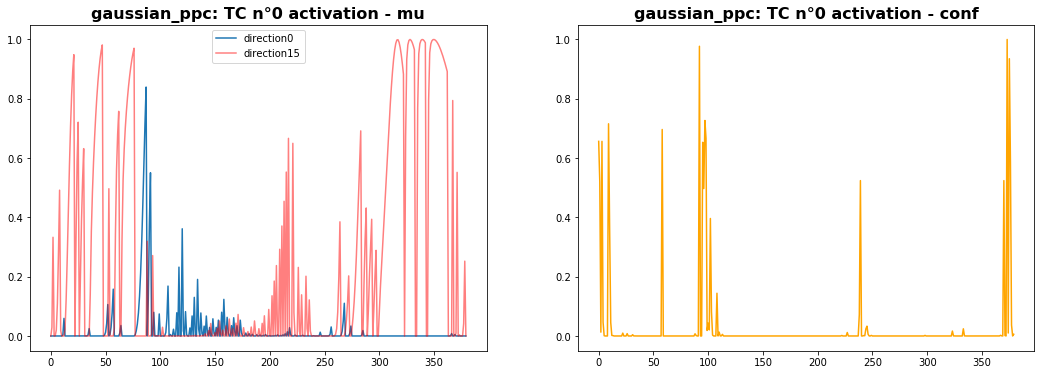

In [380]:
k_fit_scheme = 0
fit_scheme = scheme_array[k_fit_scheme]
k_direction = 0
k_session = 0
k_tc = 0
fig = plt.figure(figsize=[18,6])
ax1 = fig.add_subplot(121)
plt.plot(tc_signal_mu[0][0][0][0], label='direction0')
plt.plot(tc_signal_mu[0][15][0][0], color='red', alpha=0.5, label='direction15')
plt.legend()
plt.title(f"{fit_scheme}: TC n°{k_tc} activation - mu", size=16, fontweight='bold')
ax2 = fig.add_subplot(122)
plt.plot(tc_signal_conf[0][0][0][0], color='orange')
plt.title(f"{fit_scheme}: TC n°{k_tc} activation - conf", size=16, fontweight='bold')

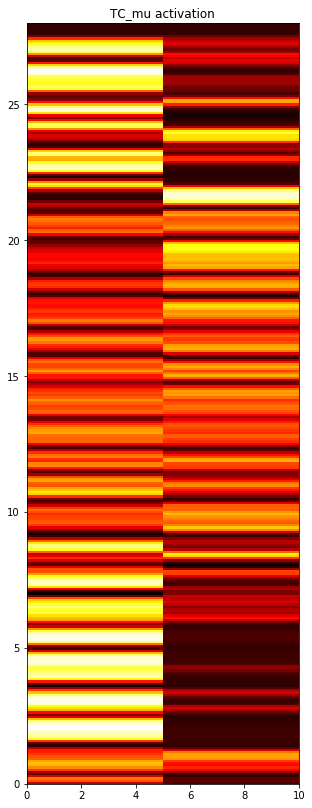

In [100]:
fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(121)
plt.title('TC_mu activation')
plt.imshow(TC_mu, norm = None, extent=[0, 10, 0, 28], cmap="hot")
if fit_scheme.find('ppc')!= -1:
    # Plot matrix for confidence
    ax1 = fig.add_subplot(122)
    plt.title('TC_conf activation')
    plt.imshow(TC_conf, norm = None, extent=[0, 10, 0, 28], cmap="hot")
    plt.show()

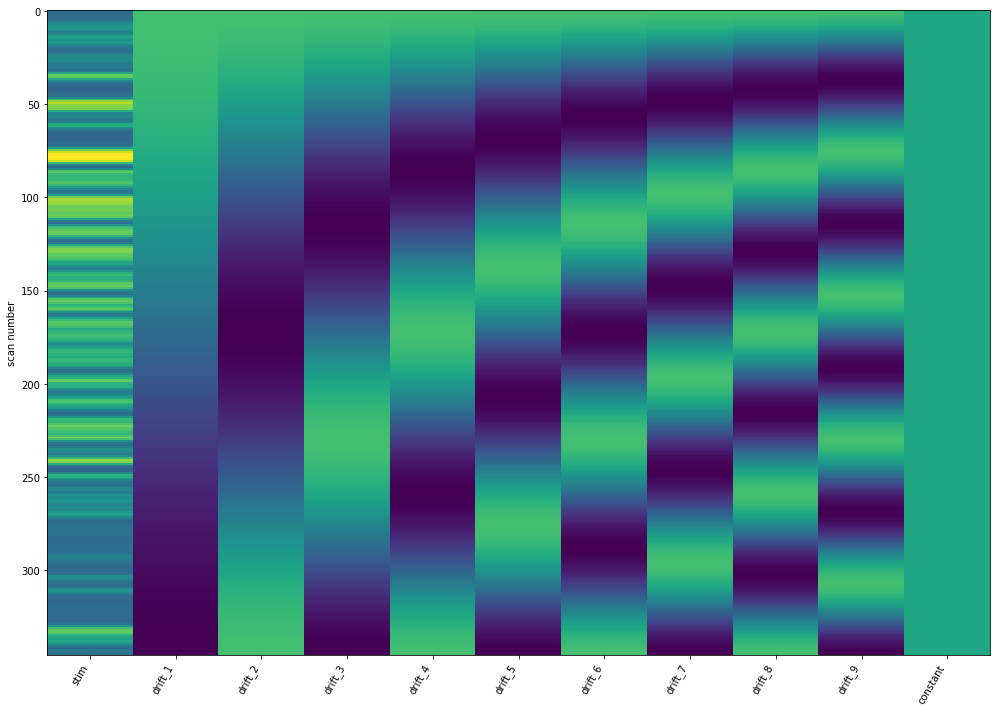

In [102]:
fig = plt.figure(figsize=[14,10])

# Plot matrix for mu
if fit_scheme.find('dpc')!= -1:
    ax1 = fig.add_subplot(111)
    plot_design_matrix(X[k_fit_scheme][k_direction][k_session], ax=ax1)

else:
    # Plot matrix for mu
    ax1 = fig.add_subplot(211)
    plot_design_matrix(X_mu[k_fit_scheme][k_direction][k_session], ax=ax1)
    plt.title('Design matrix with mu')
    # Plot matrix for confidence
    ax2 = fig.add_subplot(212)
    plot_design_matrix(X_conf[k_fit_scheme][k_direction][k_session], ax=ax2)
    plt.title('Design matrix with confidence')

In [91]:
events = pd.DataFrame({'onset': onsets[k_session], 'duration': duration[k_session], 'trial_type': conditions[k_session]})

In [92]:
## Load movement regressors
motion_file = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/rp_aepi_sess1_sb120316_20140909_08.txt'
numconv = lambda x : str.replace(x.decode('utf-8'), 'D', 'E')
motion = np.loadtxt(motion_file, converters={0:numconv, 1:numconv, 2:numconv,
                                   3:numconv, 4:numconv, 5:numconv})
#motion = np.cumsum(np.random.randn(n_scans, 6), 0)  # simulate motion

In [93]:
# Concatenate the tuning curves and motion movements for defining the model regressors
add_regs_mu = np.hstack((TC_mu, motion))
if fit_scheme.find('ppc')!= -1:
    add_regs_conf = np.hstack((TC_conf, motion))
    print(add_regs_conf.shape)

(346, 8)


In [94]:
add_reg_names_mu = [f"TC{k+1}_mu" for k in range(fit_N)]
if fit_scheme.find('ppc')!= -1:
    add_reg_names_conf = [f"TC{k+1}_conf" for k in range(fit_N)]

for k in range(motion.shape[1]):
    add_reg_names_mu.append(f"mvt{k}")
    if fit_scheme.find('ppc')!= -1:
        add_reg_names_conf.append(f"mvk{k}")

In [120]:
design_matrix_mu = make_first_level_design_matrix(frame_times, events, drift_model='cosine', period_cut=128,
                                   add_regs=add_regs_mu, add_reg_names=add_reg_names_mu, hrf_model='spm')
design_matrix_mu['session1'], design_matrix_mu['session2'], design_matrix_mu['session3'], design_matrix_mu['session4'] = [0, 0, 0, 0]
design_matrix_mu[f"session{k_session+1}"] = 1
if fit_scheme.find('ppc')!= -1:
    design_matrix_conf = make_first_level_design_matrix(frame_times, events, drift_model='cosine', period_cut=128,
                                   add_regs=add_regs_conf, add_reg_names=add_reg_names_conf, hrf_model='spm')

/home/tb258044/.local/lib/python3.7/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/tb258044/.local/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/tb258044/.local/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


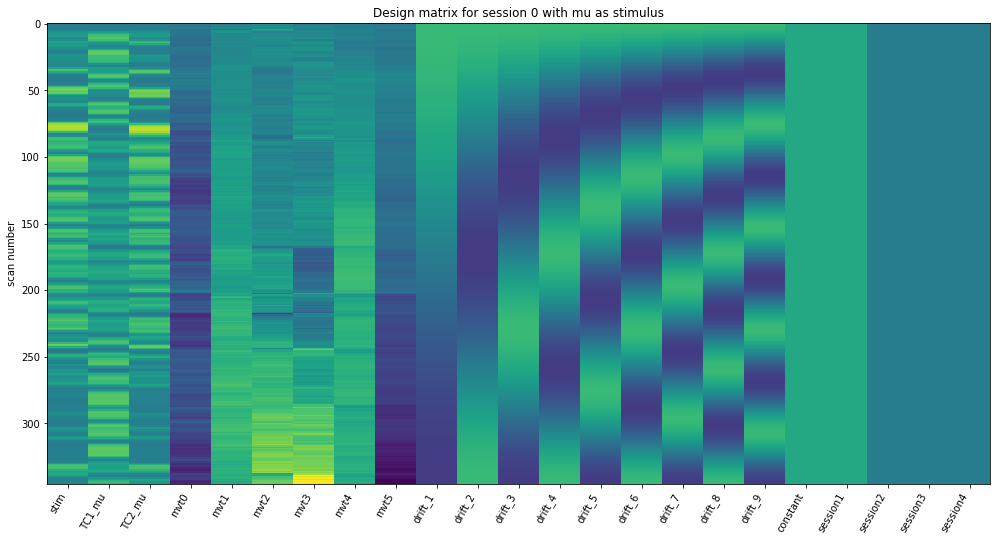

In [121]:
plt.figure(figsize=(14, 14))
ax1 = plt.subplot(211)
plot_design_matrix(design_matrix_mu, ax=ax1)
plt.title(f'Design matrix for session {k_session} with mu as stimulus')
if fit_scheme.find('ppc')!= -1:
    ax2 = plt.subplot(212)
    plot_design_matrix(design_matrix_conf, ax=ax2)
    plt.title(f'Design matrix for session {k_session} with confidence as stimulus')
plt.show()